In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Callable, List

In [2]:
@dataclass
class Function:
    func: Callable[[float], float]
    derivative: Callable[[float], float]

In [17]:
class Perceptron:
    def __init__(
        self,
        input_layer_size: int,
        hidden_layer_size: int,
        hidden_layers_count: int,
        output_layer_size: int,
        init_weights_function: Callable[[tuple], tuple],
        activation_function: Function,
        loss_function: Function,
        epochs: int,
        learning_rate: float = 0.01,
    ):
        self.input_layer_size = input_layer_size
        self.hidden_layer_size = hidden_layer_size
        self.hidden_layers_count = hidden_layers_count
        self.output_layer_size = output_layer_size
        self.activation_function = activation_function
        self.loss_function = loss_function
        self.epochs = epochs
        self.learning_rate = learning_rate

        # Инициализация весов для входного и первого скрытого слоя
        self.weights = []
        self.biases = []
        
        # Веса между входным слоем и первым скрытым слоем
        self.weights.append(init_weights_function((hidden_layer_size, input_layer_size)))
        self.biases.append(np.random.randn(hidden_layer_size))

        # Веса между скрытыми слоями
        for _ in range(hidden_layers_count - 1):
            self.weights.append(init_weights_function((hidden_layer_size, hidden_layer_size)))
            self.biases.append(np.random.randn(hidden_layer_size))

        # Веса между последним скрытым слоем и выходным слоем
        self.weights.append(init_weights_function((output_layer_size, hidden_layer_size)))
        self.biases.append(np.random.randn(output_layer_size))

    @staticmethod
    def softmax(x):
        exp_x = np.exp(x - np.max(x))  # Избегаем переполнения
        return exp_x / exp_x.sum(axis=0)

    def predict(self, X: np.ndarray, get_probabilities: bool=False) -> int | List[int]:
        current_input = X

        # Прямой проход через скрытые слои
        for i in range(self.hidden_layers_count):
            z = np.dot(self.weights[i], current_input) + self.biases[i]  # Линейное преобразование
            current_input = self.activation_function.func(z)  # Применение активационной функции

        # Прямой проход через выходной слой
        z = np.dot(self.weights[-1], current_input) + self.biases[-1]
        output = self.softmax(z)

        return output if get_probabilities else int(np.argmax(output))

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        # Преобразуем метки y в формат "one-hot encoding"
        y_one_hot = np.zeros((len(y), self.output_layer_size))
        for i, label in enumerate(y):
            y_one_hot[i, label] = 1

        for epoch in range(self.epochs):
            for i in range(len(X)):
                # Прямой проход (вычисление предсказания)
                outputs = [X[i]]  # Сохраняем выходы каждого слоя
                current_input = np.array(X[i])

                # Прямой проход через скрытые слои
                for j in range(self.hidden_layers_count):
                    z = np.dot(self.weights[j], current_input) + self.biases[j]
                    current_input = self.activation_function.func(z)
                    outputs.append(current_input)  # Сохраняем выход для дальнейшего использования

                # Прямой проход через выходной слой
                z = np.dot(self.weights[-1], current_input) + self.biases[-1]
                output = self.softmax(z)
                outputs.append(output)

                # Вычисление ошибки и градиента функции потерь
                loss_gradient = self.loss_function.derivative(output, y_one_hot[i])

                # Обратное распространение ошибки для выходного слоя
                delta = loss_gradient * self.activation_function.derivative(outputs[-1])
                self.weights[-1] -= self.learning_rate * np.outer(delta, outputs[-2])
                self.biases[-1] -= self.learning_rate * delta

                # Обратное распространение для скрытых слоев
                for j in range(self.hidden_layers_count - 1, -1, -1):
                    delta = np.dot(self.weights[j + 1].T, delta) * self.activation_function.derivative(outputs[j + 1])
                    self.weights[j] -= self.learning_rate * np.outer(delta, outputs[j])
                    self.biases[j] -= self.learning_rate * delta

    def evaluate(self, X: np.ndarray, y: np.ndarray) -> float:
        correct_predictions = 0

        for i in range(len(X)):
            prediction = self.predict(X[i])
            if prediction == y[i]:
                correct_predictions += 1

        # Возвращаем долю правильных предсказаний
        return correct_predictions / len(X)

    def validate(self, X_val: np.ndarray, y_val: np.ndarray) -> float:
        total_loss = 0.0
        n = len(X_val)

        # Преобразуем метки в one-hot encoding, если это необходимо
        y_one_hot = np.zeros((len(y_val), self.output_layer_size))
        for i, label in enumerate(y_val):
            y_one_hot[i, label] = 1

        for i in range(n):
            # Прямой проход для получения предсказания
            prediction = self.predict(X_val[i], get_probabilities=True)
            
            # Вычисляем функцию потерь для текущего примера
            loss = self.loss_function.func(prediction, y_one_hot[i])
            total_loss += loss

        # Возвращаем среднее значение функции потерь
        return total_loss / n

In [4]:
def he_init(size):
    return np.random.randn(*size) * np.sqrt(2.0 / size[1])

def xavier_init(size):
    return np.random.randn(*size) * np.sqrt(1.0 / size[1])

In [5]:
k = 3
ReLU = Function(
    func=np.vectorize(lambda x: (k * x if x > 0 else 0)),
    derivative=np.vectorize(lambda x: k if x > 0 else 0),
)

In [78]:
MSE = Function(
    func=lambda y_pred, y_true: np.mean((y_true - y_pred) ** 2),
    derivative=lambda y_pred, y_true: 2 * (y_pred - y_true) / y_true.size,
)
CrossEntropy = Function(
    func=lambda y_pred, y_true: -np.sum(y_true * np.log(y_pred + 1e-9)),
    derivative=lambda y_pred, y_true: y_pred - y_true
)
KL_Divergence = Function(
    func=lambda y_pred, y_true: -np.log(y_pred[np.argmax(y_true)]),
    derivative=lambda y_pred, y_true: -y_true / (y_pred + 1e-9)
)

In [7]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28**2) / 255
x_test = x_test.reshape(-1, 28**2) / 255
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [79]:
model_default = Perceptron(
    input_layer_size=28**2,
    hidden_layer_size=256,
    hidden_layers_count=4,
    output_layer_size=10,
    init_weights_function=he_init,
    activation_function=ReLU,
    loss_function=MSE,
    epochs=1,
    learning_rate=1e-15,
)
model_MSE = copy.deepcopy(model_default)
model_MSE.loss_function = MSE
model_CrEntr = copy.deepcopy(model_default)
model_CrEntr.loss_function = CrossEntropy
model_KL_D = copy.deepcopy(model_default)
model_KL_D.loss_function = KL_Divergence

In [26]:
epochs_count = 30

epoch_list = list(range(0, epochs_count + 1))

accuracies_MSE = [model_MSE.evaluate(x_test, y_test)]
accuracies_loss_MSE = [model_MSE.validate(x_test, y_test)]

accuracies_CrEntr = [model_CrEntr.evaluate(x_test, y_test)]
accuracies_loss_CrEntr = [model_CrEntr.validate(x_test, y_test)]

accuracies_KL_D = [model_KL_D.evaluate(x_test, y_test)]
accuracies_loss_KL_D = [model_KL_D.validate(x_test, y_test)]

In [ ]:


for i in range(1, epochs_count + 1):
    model_MSE.fit(x_train, y_train)
    accuracies_MSE.append(model_MSE.evaluate(x_test, y_test))
    accuracies_loss_MSE.append(model_MSE.validate(x_test, y_test))

In [ ]:


for i in range(1, epochs_count + 1):
    model_CrEntr.fit(x_train, y_train)
    accuracies_CrEntr.append(model_CrEntr.evaluate(x_test, y_test))
    accuracies_loss_CrEntr.append(model_CrEntr.validate(x_test, y_test))

In [80]:
for i in range(1, epochs_count + 1):
    model_KL_D.fit(x_train, y_train)
    accuracies_KL_D.append(model_KL_D.evaluate(x_test, y_test))
    accuracies_loss_KL_D.append(model_KL_D.validate(x_test, y_test))

C:\Users\angel\AppData\Local\Temp\ipykernel_12824\1043796801.py:10: RuntimeWarning: divide by zero encountered in log
  func=lambda y_pred, y_true: -np.log(y_pred[np.argmax(y_true)]),


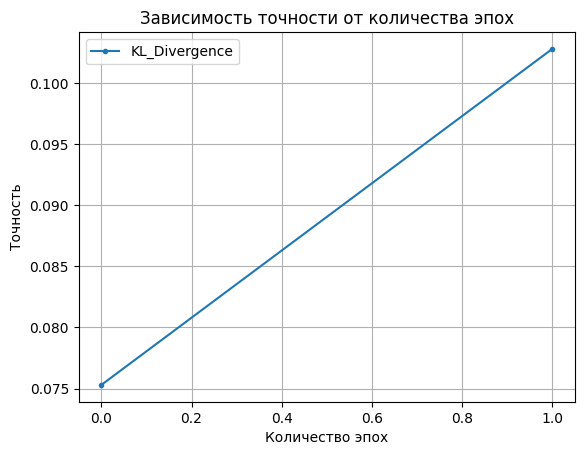

In [81]:
plt.plot(epoch_list, accuracies_MSE, marker=".", label="MSE")
plt.plot(epoch_list, accuracies_CrEntr, marker=".", label="CrossEntropy")
plt.plot(epoch_list, accuracies_KL_D, marker=".", label="KL_Divergence")

plt.title("Зависимость точности от количества эпох")
plt.xlabel("Количество эпох")
plt.ylabel("Точность")
plt.grid(True)
plt.legend()
plt.show()

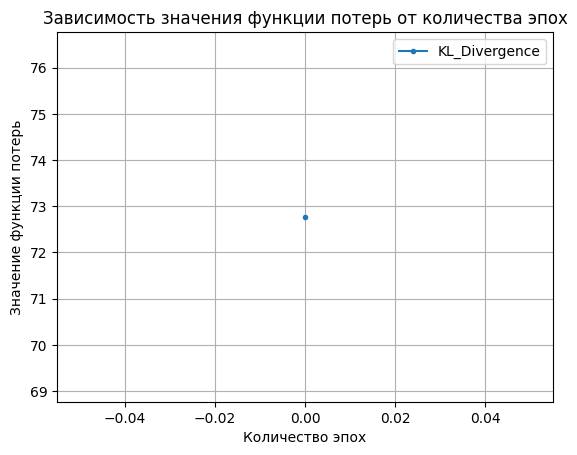

In [82]:
plt.plot(epoch_list, accuracies_loss_MSE, marker=".", label="MSE")
plt.plot(epoch_list, accuracies_loss_CrEntr, marker=".", label="CrossEntropy")
plt.plot(epoch_list, accuracies_loss_KL_D, marker=".", label="KL_Divergence")

plt.title("Зависимость значения функции потерь от количества эпох")
plt.xlabel("Количество эпох")
plt.ylabel("Значение функции потерь")
plt.grid(True)
plt.legend()
plt.show()